# Network Training
Having implemented and tested all the components of the final networks in steps 1-3, we are now ready to train the network on a large dataset (ImageNet).

In [1]:
import os
import gc
import datetime

import pandas as pd
import numpy as np

from copy import deepcopy
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras import backend as K

import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

from libs.pconv_model import PConvUnet
from libs.util import random_mask, single_rect_mask

%load_ext autoreload
%autoreload 2
plt.ioff()

# SETTINGS
TRAIN_DIR = r"D:\Documents\Kaggle\Kaggle-imagenet\input\DET\train\ILSVRC2013_train\\"
TEST_DIR = r"D:\Documents\Kaggle\Kaggle-imagenet\input\DET\pexels\\"
VAL_DIR = r"D:\Documents\Kaggle\Kaggle-imagenet\input\DET\val\val_100\\"\
    
TRAIN_DIR = "/home/srihari/Projects/PConv-Keras/data/train"
TEST_DIR = "/home/srihari/Projects/PConv-Keras/data/test"
VAL_DIR = "/home/srihari/Projects/PConv-Keras/data/val"


MODEL_WEIGHT_PATH = "/home/srihari/Projects/PConv-Keras/model"


BATCH_SIZE = 4

IMG_TARGET_SIZE = (256, 256)

TENSORBOARD_LOG_DIR = "/home/srihari/Projects/PConv-Keras/logs"

Using TensorFlow backend.


# Creating train & test data generator

In [2]:
class DataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        print(directory)
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)
        while True:
            
            # Get augmentend image samples
            ori = next(generator)

            # Get masks for each image sample
            # mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)
            
            # Get masks for each image sample
            mask = np.stack([single_rect_mask(ori.shape[1], ori.shape[2], ori.shape[3], 
                                              max_rh=50, max_rw=50, 
                                              min_rh=25, min_rw=25) 
                             for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori
            
# Create training generator
train_datagen = DataGenerator(  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_TARGET_SIZE, batch_size=BATCH_SIZE
)

# Create validation generator
val_datagen = DataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR, target_size=IMG_TARGET_SIZE, batch_size=BATCH_SIZE, seed=1
)

# Create testing generator
test_datagen = DataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_TARGET_SIZE, batch_size=BATCH_SIZE, seed=1
)

/home/srihari/Projects/PConv-Keras/data/test
Found 1000 images belonging to 1 classes.


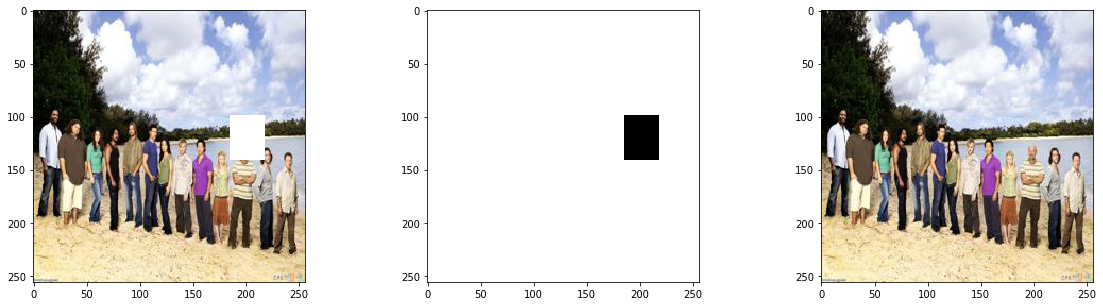

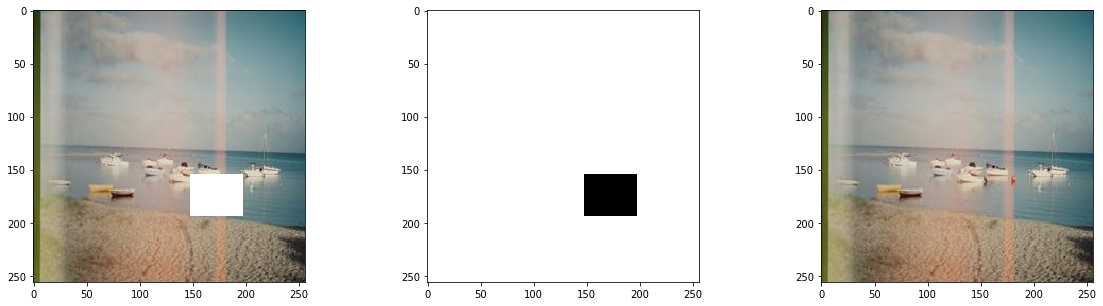

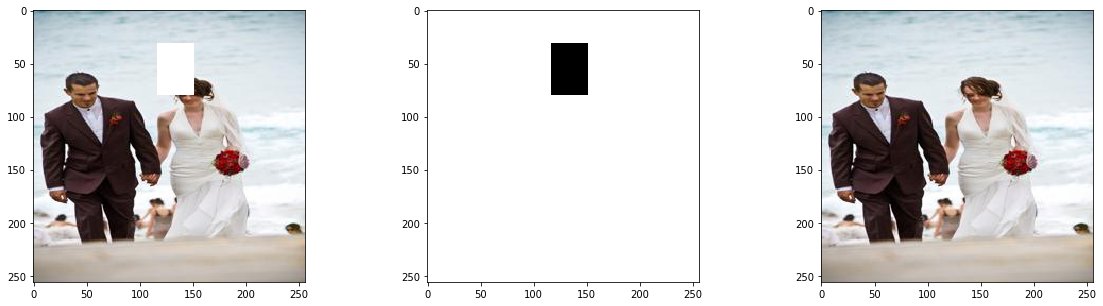

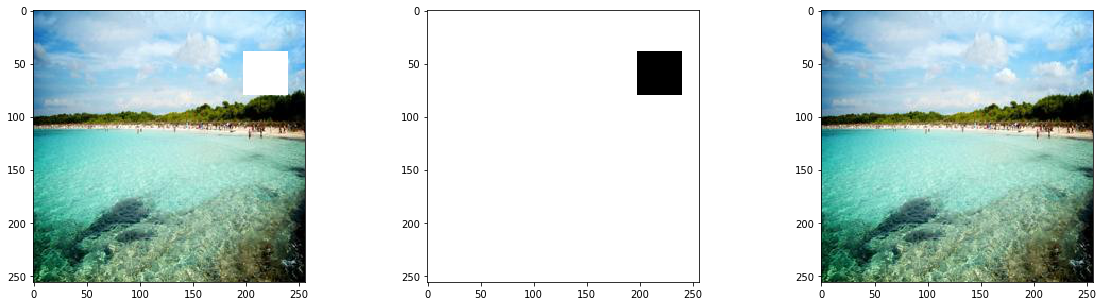

In [3]:
# Pick out an example
test_data = next(test_generator)
(masked, mask), ori = test_data

# Show side by side
for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

# Training on ImageNet

In [4]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
                
        plt.savefig(r'data/test_samples/img_{}_{}.png'.format(i, pred_time))
        plt.close()

## Phase 1 - with batch normalization

In [7]:
# Instantiate the model
# model = PConvUnet(weight_filepath='data/logs/')
# model.load(r"C:\Users\MAFG\Documents\Github-Public\PConv-Keras\data\logs\50_weights_2018-06-01-16-41-43.h5")

In [5]:
model = PConvUnet(weight_filepath=MODEL_WEIGHT_PATH)
model.load(r"/home/srihari/Projects/PConv-Keras/model/123_weights_2019-01-06-13-48-21.h5")

In [6]:
# Run training for certain amount of epochs
# model.fit(
#     train_generator, 
#     steps_per_epoch=10000,
#     validation_data=val_generator,
#     validation_steps=100,
#     epochs=50,        
#     plot_callback=plot_callback,
#     callbacks=[
#         TensorBoard(log_dir='../data/logs/initial_training', write_graph=False)
#     ]
# )


model.fit(
    train_generator, 
    steps_per_epoch=250,
    validation_data=val_generator,
    validation_steps=100,
    epochs=50,        
    plot_callback=plot_callback,
    callbacks=[
        TensorBoard(log_dir=TENSORBOARD_LOG_DIR, write_graph=False)
    ]
)

Epoch 124/124
/home/srihari/Projects/PConv-Keras/data/val
/home/srihari/Projects/PConv-Keras/data/train
Found 3499 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
250/250 [==============================] - 618s 2s/step - loss: 63350.6235 - val_loss: 79795.9823
Epoch 125/125
250/250 [==============================] - 620s 2s/step - loss: 59778.7508 - val_loss: 82705.6687
Epoch 126/126
250/250 [==============================] - 597s 2s/step - loss: 60121.5160 - val_loss: 79179.2637
Epoch 127/127
250/250 [==============================] - 605s 2s/step - loss: 57866.7035 - val_loss: 81276.7457
Epoch 128/128
250/250 [==============================] - 601s 2s/step - loss: 59206.5157 - val_loss: 79421.6790
Epoch 129/129
250/250 [==============================] - 601s 2s/step - loss: 59214.2377 - val_loss: 82860.5477
Epoch 130/130
250/250 [==============================] - 601s 2s/step - loss: 57185.1123 - val_loss: 79276.6432
Epoch 131/131
250/250 [===================

## Phase 2 - without batch normalization

In [5]:
# Load weights from previous run
model = PConvUnet(weight_filepath=MODEL_WEIGHT_PATH)
model.load(
    os.path.join(MODEL_WEIGHT_PATH,"175_weights_2019-01-08-09-59-48.h5"),
    train_bn=False,
    lr=0.00005
)

In [6]:
# Run training for certain amount of epochs
model.fit(
    train_generator, 
    steps_per_epoch=250,
    validation_data=val_generator,
    validation_steps=100,
    epochs=20,        
    workers=1,
    plot_callback=plot_callback,
    callbacks=[
        TensorBoard(log_dir=TENSORBOARD_LOG_DIR, write_graph=False)
    ]
)

Epoch 176/176
/home/srihari/Projects/PConv-Keras/data/train
/home/srihari/Projects/PConv-Keras/data/val
Found 826 images belonging to 1 classes.
Found 3499 images belonging to 1 classes.
250/250 [==============================] - 628s 3s/step - loss: 52054.6571 - val_loss: 47454.6284
Epoch 177/177
250/250 [==============================] - 635s 3s/step - loss: 50716.3565 - val_loss: 50377.5974
Epoch 178/178
250/250 [==============================] - 613s 2s/step - loss: 50650.2042 - val_loss: 46193.1726
Epoch 179/179
250/250 [==============================] - 600s 2s/step - loss: 48395.3360 - val_loss: 43661.0100
Epoch 180/180
250/250 [==============================] - 597s 2s/step - loss: 48872.2565 - val_loss: 55023.4585
Epoch 181/181
250/250 [==============================] - 597s 2s/step - loss: 49530.6347 - val_loss: 46385.3674
Epoch 182/182
250/250 [==============================] - 597s 2s/step - loss: 45993.2450 - val_loss: 45896.6226
Epoch 183/183
250/250 [====================

## Phase 3 - Generating samples

In [9]:
# Load weights from previous run
model = PConvUnet(weight_filepath=MODEL_WEIGHT_PATH)
model.load(
    r"C:\Users\MAFG\Documents\Github-Public\PConv-Keras\data\logs\170_weights_2018-06-28-15-00-38.h5",
    train_bn=False,
    lr=0.00005
)

7it [00:09,  1.39s/it]

SystemError: <built-in method write of _io.BufferedWriter object at 0x7f3115c13eb8> returned a result with an error set

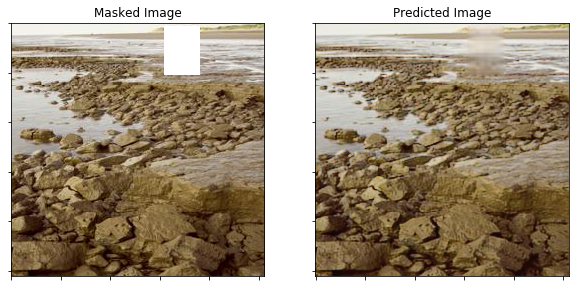

In [7]:
n = 0
for (masked, mask), ori in tqdm(test_generator):
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[0].xaxis.set_major_formatter(NullFormatter())
        axes[0].yaxis.set_major_formatter(NullFormatter())
        axes[1].xaxis.set_major_formatter(NullFormatter())
        axes[1].yaxis.set_major_formatter(NullFormatter())
                
        plt.savefig(r'data/test_samples/img_{}_{}.png'.format(i, pred_time))
        plt.close()
        n += 1
        
    # Only create predictions for about 100 images
    if n > 100:
        break

### Test on specifc use cases


In [5]:
model = PConvUnet(weight_filepath=MODEL_WEIGHT_PATH)
model.load(
    os.path.join(MODEL_WEIGHT_PATH,"195_weights_2019-01-08-13-49-16.h5"),
    train_bn=False,
    lr=0.00005
)

/home/srihari/Projects/PConv-Keras/data/specific_test
Found 1 images belonging to 1 classes.


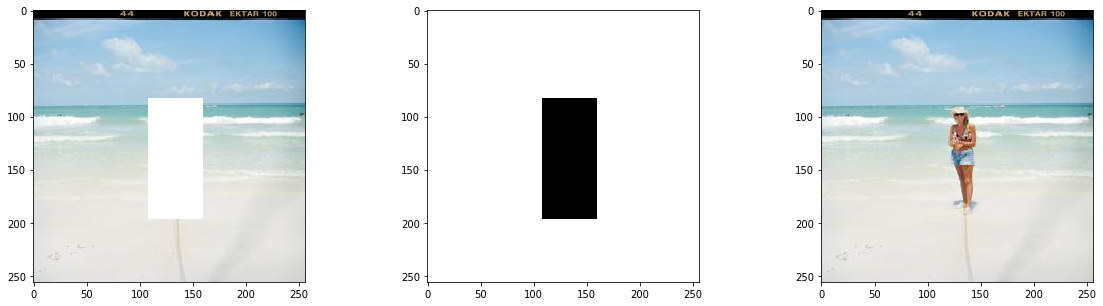

In [8]:
# Create specific testing generator
class SpecDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        print(directory)
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)
        while True:
            
            # Get augmentend image samples
            ori = next(generator)

            # Get masks for each image sample
            # mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)
            
            # Get masks for each image sample
            mask = np.ones(ori.shape)
            
            # 106, 72, 56, 26
#             mask[:, 106:160, 72:108, :] = 0
            
            #  83, 108, 114, 52 
            mask[:, 83:197, 108:160, :] = 0

            # 87, 71, 96, 41,
#             mask[:, 87:183, 71:112, :] = 0
            
            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori
            
            
SPECTEST_DIR = "/home/srihari/Projects/PConv-Keras/data/specific_test"
spectest_datagen = SpecDataGenerator(rescale=1./255)
spectest_generator = spectest_datagen.flow_from_directory(
    SPECTEST_DIR, target_size=IMG_TARGET_SIZE, batch_size=BATCH_SIZE, seed=1
)

# Pick out an example
spectest_data = next(spectest_generator)
(masked, mask), ori = spectest_data

# Show side by side
for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

0it [00:00, ?it/s]

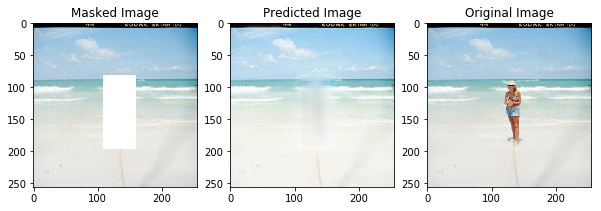

1it [00:00,  1.23it/s]

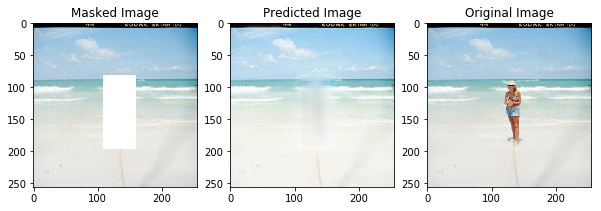

In [9]:
n = 0
for (masked, mask), ori in tqdm(spectest_generator):
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(10, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
        plt.savefig(r'/home/srihari/Projects/PConv-Keras/data/spectest_res/img_{}_{}.png'.format(i, pred_time))
        plt.show()
        plt.close()
        n += 1
        
    # Only create predictions for about 100 images
    if n > 1:
        break